In [204]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from pydicom import read_file
import re

PROJ_DIR = "/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler"

JOINT_PATH = os.path.join(PROJ_DIR, "joint_export/dwh_tables")

EXPORT_1 = os.path.join(PROJ_DIR, "dwh_tables")
EXPORT_2 = os.path.join(PROJ_DIR, "Studies2_202012/dwh_tables")

OCT_DIR_EXPORT_1 = os.path.join(PROJ_DIR, "Studies/Optical Coherence Tomography Scanner")
OCT_DIR_EXPORT_2 = os.path.join(PROJ_DIR, "Studies2_202012/OPT")

DIR_EXPORT_1 = os.path.join(PROJ_DIR, "Studies")
DIR_EXPORT_2 = os.path.join(PROJ_DIR, "Studies2_202012")

## Join OCT meta tables from both exports

In [205]:
oct_meta_export_1 = os.path.join(DIR_EXPORT_1, 'oct_meta_information.csv')
oct_meta_export_2 = os.path.join(DIR_EXPORT_2, 'oct_meta_information.csv')

oct_meta_export_1_pd = pd.read_csv(oct_meta_export_1)
oct_meta_export_2_pd = pd.read_csv(oct_meta_export_2)

#### pre process tables

In [206]:
oct_meta_export_1_pd["PATNR"] = oct_meta_export_1_pd.PATNR.str.replace("ps:", "")
oct_meta_export_1_pd = oct_meta_export_1_pd.drop(columns={"Unnamed: 0"})

oct_meta_export_2_pd = oct_meta_export_2_pd.drop(columns={"Unnamed: 0"})

# remove nan patients
oct_meta_export_2_pd = oct_meta_export_2_pd[~oct_meta_export_2_pd.PATNR.isna()]
oct_meta_export_1_pd = oct_meta_export_1_pd[~oct_meta_export_1_pd.PATNR.isna()]

# convert PATNR to int
oct_meta_export_1_pd.loc[:, "PATNR"] = oct_meta_export_1_pd.PATNR.astype(int)

### check for duplicate birthdays or Genders

In [207]:
# birthday


'''
test patients as provided by Nastassya:

'''

patients = [183,  187,  224,  281,  289,  319,  335,  358,  401,  407,  498,  500,  502,  526]


for k, oct_meta_file in enumerate([oct_meta_export_1_pd, oct_meta_export_2_pd]):
    for patient in patients:
        patient_filter = oct_meta_file.PATNR == patient
        n_birthdays = oct_meta_file[patient_filter].birthdate.drop_duplicates().shape[0]
        assert n_birthdays <= 1, f"duplicate birthdays for patient {patient}"
        

# gender

'''
test patients as provided by Nastassya:

'''
patients = [257985, 367544, 373514]

for k, oct_meta_file in enumerate([oct_meta_export_1_pd, oct_meta_export_2_pd]):
    for patient in patients:
        patient_filter = oct_meta_file.PATNR == patient
        n_genders = oct_meta_file[patient_filter].gender.drop_duplicates().shape[0]
        try:
            assert n_genders <= 1, f"duplicate gender for patient {patient}"
        except:
            print(f"duplicate gender for patient {patient}")

duplicate gender for patient 257985
duplicate gender for patient 367544
duplicate gender for patient 373514
duplicate gender for patient 367544


In [208]:
# birthday between exports
patients = [18,
 502,
 709,
 719,
 735,
 1263,
 1263,
 1475,
 1557,
 1764,
 1826,
 2005,
 2005,
 3213,
 3828,
 4206,
 4206,
 4724]


for patient in patients:
    patient_filter_export_1 = oct_meta_export_1_pd.PATNR == patient
    patient_filter_export_2 = oct_meta_export_2_pd.PATNR == patient
    
    b1 = oct_meta_export_1_pd[patient_filter_export_1].birthdate
    b2 =  oct_meta_export_2_pd[patient_filter_export_2].birthdate
    
    if b1.size > 0 and (b2.size > 0):
        b1 = b1.drop_duplicates().iloc[0]
        b2 = b2.drop_duplicates().iloc[0]
    else:
        continue
    try:
        assert b1 == b2, "birthdays different in each export"
    except:
        print(f"birthday different. Patient:  {patient} Export 1: {b1} - Export 2: {b2}.")

birthday different. Patient:  502 Export 1: 19340101 - Export 2: 19340501.
birthday different. Patient:  709 Export 1: 19380101 - Export 2: 19380701.
birthday different. Patient:  719 Export 1: 19400101 - Export 2: 19400701.
birthday different. Patient:  735 Export 1: 19500101 - Export 2: 19500701.
birthday different. Patient:  1475 Export 1: 19450101 - Export 2: 19450301.
birthday different. Patient:  1557 Export 1: 19360101 - Export 2: 19360401.
birthday different. Patient:  1764 Export 1: 19390101 - Export 2: 19390601.
birthday different. Patient:  1826 Export 1: 19330101 - Export 2: 19330701.
birthday different. Patient:  2005 Export 1: 19360101 - Export 2: 19360901.
birthday different. Patient:  2005 Export 1: 19360101 - Export 2: 19360901.
birthday different. Patient:  3213 Export 1: 19350101 - Export 2: 19351101.
birthday different. Patient:  3828 Export 1: 19470101 - Export 2: 19470601.
birthday different. Patient:  4206 Export 1: 19330101 - Export 2: 19331101.
birthday differe

#### Filter DICOMS of right type and img shape

In [209]:
export2_study_descr_bool = oct_meta_export_2_pd.study_description == 'Makula (OCT)'
export2_img_shape_bool = oct_meta_export_2_pd.img_shape == '(49, 496, 512)'

print("Number of DICOMS before filtering: ", oct_meta_export_2_pd.shape[0])

oct_meta_export_2_pd = oct_meta_export_2_pd[export2_study_descr_bool & export2_img_shape_bool]

print("Number of DICOMS after filtering: ", oct_meta_export_2_pd.shape[0])

Number of DICOMS before filtering:  244533
Number of DICOMS after filtering:  165371


In [210]:
export1_study_descr_bool = oct_meta_export_1_pd.study_description == 'Makula (OCT)'
export1_img_shape_bool = oct_meta_export_1_pd.img_shape == '(49, 496, 512)'

print("Number of DICOMS before filtering: ", oct_meta_export_1_pd.shape[0])

oct_meta_export_1_pd = oct_meta_export_1_pd[export1_study_descr_bool & export1_img_shape_bool]

print("Number of DICOMS after filtering: ", oct_meta_export_1_pd.shape[0])

Number of DICOMS before filtering:  170877
Number of DICOMS after filtering:  136226


### Append meta tables and drop duplicates

In [211]:
print(f"Number of OCT studies from export 1: {oct_meta_export_1_pd.shape[0]} \
      and export 2: {oct_meta_export_2_pd.shape[0]}")

# assign column stating export
oct_meta_export_1_pd["export"] = "1"
oct_meta_export_2_pd["export"] = "2"

joint_meta_pd = oct_meta_export_1_pd.append(oct_meta_export_2_pd)

print("Number of records bef drop: ", joint_meta_pd.shape[0])

joint_meta_pd = joint_meta_pd.drop_duplicates(subset=joint_meta_pd.columns)

print("Number of records after drop: ", joint_meta_pd.shape[0])

print(f"Number of added OCTs from second export: {joint_meta_pd.shape[0] - oct_meta_export_1_pd.shape[0]}")

Number of OCT studies from export 1: 136226       and export 2: 165371


/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Number of records bef drop:  301597
Number of records after drop:  290540
Number of added OCTs from second export: 154314


#### Add dicom path to each OCT record

In [212]:
joint_export_dicom_paths = pd.read_csv(os.path.join(PROJ_DIR, "joint_export/dicom_paths.csv"))
path_info = joint_export_dicom_paths["0"].str.split("/", expand=True)[[9, 10, 11, 12]]

# add export info
path_info["export"] = joint_export_dicom_paths["0"].str.split("/", expand=True)[7]

# convert laterality format
path_info[10] = path_info[10].str.replace("Left", "L").str.replace("Right", "R")

joint_meta_pd["study_date"] = joint_meta_pd["study_date"].astype(str)
joint_meta_pd["PATNR"] = joint_meta_pd.PATNR.astype(str)

In [213]:
## Check data Quality (duplicate patients and birthdays)

In [214]:
joint_meta_export_1_pd = joint_meta_pd[joint_meta_pd.export=="1"]
joint_meta_export_2_pd = joint_meta_pd[joint_meta_pd.export=="2"]

In [215]:
joint_meta_exp_1_pd = pd.merge(joint_meta_export_1_pd, path_info[path_info.export=="Studies"], 
                         left_on=["PATNR", "laterality", "study_date"], 
                         right_on=[9, 10, 11], how="left")

joint_meta_exp_2_pd = pd.merge(joint_meta_export_2_pd, path_info[path_info.export=="Studies2_202012"], 
                         left_on=["PATNR", "laterality", "study_date"], 
                         right_on=[9, 10, 11], how="left")

#### drop, rename thus align columns for appending

In [216]:
joint_meta_exp_1_pd.drop(columns=[9, 10, 11, "export_y"], inplace=True)
joint_meta_exp_1_pd.rename(columns={"export_x": "export", 12: "dicom_name"}, inplace=True)

In [217]:
joint_meta_exp_2_pd.drop(columns=[9, 10, 11, "export_y"], inplace=True)
joint_meta_exp_2_pd.rename(columns={"export_x": "export", 12: "dicom_name"}, inplace=True)

In [218]:
joint_meta_exp_2_pd.head()

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name
0,381934,R,20200513,19450901,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",75,2,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1323383288...
1,381934,L,20200513,19450901,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",75,2,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1323383288...
2,9846,L,20181219,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1318968422...
3,9846,L,20181009,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17,2,OPt.1.3.6.1.4.1.33437.10.4.6339912.13183544275...
4,9846,L,20190213,19380501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",83,17,2,OPt.1.3.6.1.4.1.33437.10.4.6339912.13194535929...


#### Create correct laterality string for export 2 path

In [219]:
lat_exp1 = joint_meta_exp_1_pd["laterality"].copy()

lat_exp1[lat_exp1 == "R"]  = lat_exp1[lat_exp1 == "R"] + "ight"
lat_exp1[lat_exp1 == "L"]  = lat_exp1[lat_exp1 == "L"] + "eft"

In [220]:
PATH_EXT_1 = joint_meta_exp_1_pd.PATNR + "/" + lat_exp1 + "/" + joint_meta_exp_1_pd.study_date
PATH_EXT_2 = joint_meta_exp_2_pd.PATNR + "/" + joint_meta_exp_2_pd.laterality + "/" + joint_meta_exp_2_pd.study_date

joint_meta_exp_1_pd["oct_path"] = OCT_DIR_EXPORT_1 + "/" + PATH_EXT_1 + "/" + joint_meta_exp_1_pd.dicom_name
joint_meta_exp_2_pd["oct_path"] = OCT_DIR_EXPORT_2 + "/" + PATH_EXT_2 + "/" + joint_meta_exp_2_pd.dicom_name

## verify that same patient in export 1 and 2 are in fact the same

displaying oct path:  /storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler/Studies/Optical Coherence Tomography Scanner/183/Right/20180306/1.3.6.1.4.1.33437.10.4.13118731.13164795005.22408.4.1.dcm


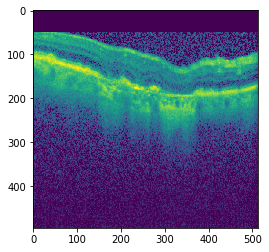

In [221]:
from pydicom import read_file

patient = "183"
laterality = "R"
study_date = "20180306"

patient_pd = joint_meta_exp_1_pd[joint_meta_exp_1_pd.PATNR == patient]
lat_pd = patient_pd[patient_pd.laterality == laterality]
study_pd = lat_pd[lat_pd.study_date == study_date]

oct_1 = read_file(study_pd.oct_path.iloc[0]).pixel_array[15, :, :]

print("displaying oct path: ", study_pd.oct_path.iloc[0])
plt.imshow(oct_1)

displaying oct path:  /storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler/Studies2_202012/OPT/183/R/20180306/OPt.1.3.6.1.4.1.33437.10.4.13118731.13164795005.22408.4.1.dcm


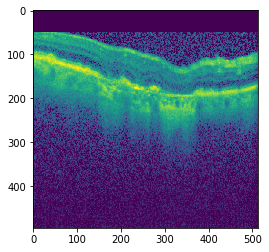

In [222]:
patient_pd = joint_meta_exp_2_pd[joint_meta_exp_2_pd.PATNR == patient]
lat_pd = patient_pd[patient_pd.laterality == laterality]
study_pd = lat_pd[lat_pd.study_date == study_date]

oct_2 = read_file(study_pd.oct_path.iloc[0]).pixel_array[15, :, :]

print("displaying oct path: ", study_pd.oct_path.iloc[0])

plt.imshow(oct_2)

#### join meta tables

In [223]:
joint_meta_pd = joint_meta_exp_1_pd.append(joint_meta_exp_2_pd)

#### Save joint meta table to joint export directory

In [224]:
joint_meta_pd.to_csv(os.path.join(PROJ_DIR, "joint_export", "oct_meta_information.csv"), index=False)

In [225]:
joint_meta_pd.head()

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name,oct_path
0,363979,R,20180129,19900101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",31,2,1,1.3.6.1.4.1.33437.10.4.4089432.13161688882.283...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
1,363979,L,20180129,19900101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",31,2,1,1.3.6.1.4.1.33437.10.4.4089432.13161688884.283...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
2,350569,R,20170306,20110101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",10,2,1,1.3.6.1.4.1.33437.10.4.4089432.13133269474.269...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
3,350569,L,20170306,20110101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",10,2,1,1.3.6.1.4.1.33437.10.4.4089432.13133269479.269...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...
4,185669,L,20141209,19720101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",49,2,1,1.3.6.1.4.1.33437.10.4.15740454.13062592861.12...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...


### Join Diagnosen and Prozeduren tables

In [226]:
print("Files in joint path", os.listdir(JOINT_PATH))

joint_prozeduren_pd = pd.read_csv(os.path.join(JOINT_PATH, 'prozeduren.csv'))
joint_diagnosis_pd = pd.read_csv(os.path.join(JOINT_PATH, 'diagnosis.csv'))

Files in joint path ['visus.csv', 'prozeduren.csv', 'tensio.csv', 'medications.csv', 'visus_labels.csv', 'diagnosis.csv', 'supplement_tables']


In [227]:
joint_prozeduren_pd.head()

,Unnamed: 0,DAT,ICPMK,ICPML,LOK,PATNR
0,0,2006-03-15 00:00:00,P4,5-984,L,17
1,1,2014-05-21 00:00:00,PC,5-091.10,L,17
2,2,2015-02-10 00:00:00,PD,5-984,NaN,17
3,3,2015-07-13 00:00:00,PD,3-300.0,NaN,17
4,4,2018-01-08 00:00:00,PG,5-156.9,R,18


In [228]:
joint_diagnosis_pd.head()

,Unnamed: 0,DAT,DKAT,DKEY,LOK,PATNR
0,0,2003-11-18 00:00:00,A1,C44.18,NaN,17
1,1,2006-03-15 00:00:00,4,J45.9,NaN,17
2,2,2006-03-15 00:00:00,AS,ASA1,NaN,17
3,3,2006-11-07 00:00:00,4,C44.1,NaN,17
4,4,2007-08-07 00:00:00,5,C44.1,NaN,17


#### remove nan values from patient id

In [229]:
joint_meta_pd = joint_meta_pd[joint_meta_pd["PATNR"] != "nan"]

### Get list of unique diagnosises for each patient

In [230]:
unique_patients = joint_meta_pd["PATNR"].drop_duplicates().tolist()

joint_diagnosis_pd["DAT_dt"] = pd.to_datetime(joint_diagnosis_pd.DAT)

diagnosis_dict = {"PATNR": [], "AMD": [], "DKEY_first_date": []}

for patient in tqdm(unique_patients):
    diagnosis_dict["PATNR"].append(patient)
    
    patient_dkat_pd = joint_diagnosis_pd[joint_diagnosis_pd.PATNR == int(patient)]
    dkeys = patient_dkat_pd.DKEY.drop_duplicates().values
    
    if any("H35.3" in str(dk) for dk in dkeys):
        amd_dates = patient_dkat_pd[patient_dkat_pd.DKEY.str.contains('H35.3').fillna(False)].DAT_dt
        
        diagnosis_dict["DKEY_first_date"].append(min(amd_dates))
        diagnosis_dict["AMD"].append(True)
    else:
        diagnosis_dict["DKEY_first_date"].append(np.nan)
        diagnosis_dict["AMD"].append(False)

100%|██████████| 34062/34062 [03:39<00:00, 154.89it/s]


#### Join DKEY info to joint meta table

In [231]:
amd_assignment = pd.DataFrame.from_dict(diagnosis_dict)
amd_assignment["PATNR"] = amd_assignment.PATNR.astype(str)

joint_meta_pd = pd.merge(joint_meta_pd, amd_assignment, left_on="PATNR", right_on="PATNR", how="left")

### Get list of unique procedures for each patient

In [232]:
prozeduren_dict = {"PATNR": [], "INJECTION": [], "INJECTION_first_date": []}

joint_prozeduren_pd["DAT_dt"] = pd.to_datetime(joint_prozeduren_pd.DAT)

for patient in tqdm(unique_patients):
    prozeduren_dict["PATNR"].append(patient)
    
    patient_prozeduren_pd = joint_prozeduren_pd[joint_prozeduren_pd.PATNR == int(patient)]
    ICPML_codes = patient_prozeduren_pd.ICPML.drop_duplicates().values
    
    if any("5-156.9" in str(code) for code in ICPML_codes):
        injection_dates = patient_prozeduren_pd[patient_prozeduren_pd.ICPML.str.contains('5-156.9')].DAT_dt
        
        prozeduren_dict["INJECTION_first_date"].append(min(injection_dates))
        prozeduren_dict["INJECTION"].append(True)
    else:
        prozeduren_dict["INJECTION_first_date"].append(np.nan)
        prozeduren_dict["INJECTION"].append(False)

100%|██████████| 34062/34062 [02:16<00:00, 249.30it/s]


#### Join Injection info to joint meta table

In [233]:
len(prozeduren_dict["PATNR"]), len(prozeduren_dict["INJECTION"]), len(prozeduren_dict["INJECTION_first_date"])

(34062, 34062, 34062)

In [234]:
injection_assignment = pd.DataFrame.from_dict(prozeduren_dict)
injection_assignment["PATNR"] = injection_assignment.PATNR.astype(str)

joint_meta_pd = pd.merge(joint_meta_pd, injection_assignment, left_on="PATNR", right_on="PATNR", how="left") 

#### Save meta table

In [235]:
EXT = "joint_export"
joint_meta_pd.to_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_information.csv"), index=False)

## Drop cross export duplicates

In [236]:
joint_meta_pd = joint_meta_pd.drop_duplicates(subset=["PATNR", "laterality", "study_date"])

## Filter for > 2 visists, join in Diagnosis and Prozeduren tables 

In [238]:
single_visit_filter = joint_meta_pd.number_of_visits > 2

joint_meta_longitudinal = joint_meta_pd[single_visit_filter]

print("Number of OCTs part of time series: ", joint_meta_longitudinal.shape[0])

Number of OCTs part of time series:  182786


In [239]:
EXT = "joint_export/longitudinal_tables"
joint_meta_longitudinal.to_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_longitudinal_information.csv"), index=False)

In [240]:
joint_meta_longitudinal

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date
6,316294,L,20160520,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16265058.13108199572.79...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
7,316294,L,20171103,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13154166623.280...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
9,316294,L,20151016,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16395944.13089451581.11...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
10,316294,L,20161118,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13123928376.265...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
11,316294,L,20170519,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13139649101.273...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326639,47073,L,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611308...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
326641,47073,R,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611307...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
326644,47073,R,20190225,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13195573665...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT
326646,407,L,20190213,19360401,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",85,4,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1319453008...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaT,False,NaT


#### Load meta table

In [51]:
EXT = "joint_export/longitudinal_tables"
joint_meta_longitudinal = pd.read_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_longitudinal_information.csv"))

In [52]:
joint_meta_longitudinal.drop_duplicates(subset=["PATNR", "laterality", "study_date"])

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,number_of_visits,export,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date
0,316294,L,20160520,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16265058.13108199572.79...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
1,316294,L,20171103,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13154166623.280...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
2,316294,L,20151016,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.16395944.13089451581.11...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
3,316294,L,20161118,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13123928376.265...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
4,316294,L,20170519,19880101,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",33,12,1,1.3.6.1.4.1.33437.10.4.4089432.13139649101.273...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182781,47073,L,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611308...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
182782,47073,R,20200522,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13234611307...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
182783,47073,R,20190225,19450501,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",76,8,2,OPt.1.3.6.1.4.1.33437.10.4.7175529.13195573665...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN
182784,407,L,20190213,19360401,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",85,4,2,OPt.1.3.6.1.4.1.33437.10.4.16073696.1319453008...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,False,NaN,False,NaN


## Load and Join Longiudinal patients from Export 1 and Export 2

In [53]:
longitudinal_export_1 = os.path.join(PROJ_DIR, EXT, "check_naive_patients_CORRECTED.csv")
longitudinal_export_2 = os.path.join(PROJ_DIR, EXT, "longitudinal_records_with_date_CHECKED.csv")

longitudinal_export_1_raw_pd = pd.read_csv(longitudinal_export_1)
longitudinal_export_2_raw_pd = pd.read_csv(longitudinal_export_2)

### Process tables formats

In [54]:
longitudinal_export_1_pd = longitudinal_export_1_raw_pd.dropna(how="all")

longitudinal_export_1_pd = longitudinal_export_1_pd.drop(columns=["Unnamed: 0", "Unnamed: 5", "Unnamed: 6", 
                                                                  "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", 
                                                                  "Unnamed: 10"])

longitudinal_export_1_pd = longitudinal_export_1_pd.rename(columns={"patient_id": "PATNR"})
longitudinal_export_1_pd.PATNR = longitudinal_export_1_pd.PATNR.astype(int)

In [55]:
longitudinal_export_2_pd = longitudinal_export_2_raw_pd.dropna(how="all")

longitudinal_export_2_pd = longitudinal_export_2_pd.drop(columns=["Unnamed: 0", "Unnamed: 9"])
longitudinal_export_2_pd = longitudinal_export_2_pd.rename(columns={"pseudo_id": "PATNR"})

longitudinal_export_2_pd.PATNR = longitudinal_export_2_pd.PATNR.astype(int)

### Mark patients in meta_pd which are in longitudinal lists

In [56]:
joint_meta_longitudinal["LONGITUDINAL_LISTS_1"] = joint_meta_longitudinal.PATNR.isin(longitudinal_export_1_pd.PATNR.values.tolist())
joint_meta_longitudinal["LONGITUDINAL_LISTS_2"] = joint_meta_longitudinal.PATNR.isin(longitudinal_export_2_pd.PATNR.values.tolist())

### Merge naive column into frame

In [57]:
joint_meta_longitudinal = pd.merge(joint_meta_longitudinal, longitudinal_export_2_pd[["PATNR", "Naive"]], 
                                   left_on="PATNR", right_on="PATNR", how="left")

In [58]:
joint_meta_longitudinal = pd.merge(joint_meta_longitudinal, longitudinal_export_1_pd[["PATNR", "Naive"]], 
                                   left_on="PATNR", right_on="PATNR", how="left")

In [61]:
joint_meta_longitudinal[joint_meta_longitudinal.Naive_y == True]

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,...,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date,LONGITUDINAL_LISTS_1,LONGITUDINAL_LISTS_2,Naive_x,Naive_y
598,29892,L,20170711,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13144246997.276...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
599,29892,L,20180411,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13167914814.288...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
600,29892,L,20171128,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.13118731.13156339954.21...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
601,29892,L,20180228,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13164297799.285...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
602,29892,L,20180723,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13176810348.294...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187681,253802,L,20191002,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.16073696.1321447038...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0
187682,253802,L,20191030,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13216892739...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0
187683,253802,L,20200219,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13226571111...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0
187684,253802,L,20190925,19350601,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",86,...,OPt.1.3.6.1.4.1.33437.10.4.6339912.13213867254...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2015-08-25,True,2015-08-25,True,False,NaN,1.0


### Get meta tables for included and excluded patients

In [62]:
included_longitudinal = joint_meta_longitudinal[(joint_meta_longitudinal.LONGITUDINAL_LISTS_1 == True) | 
                                                (joint_meta_longitudinal.LONGITUDINAL_LISTS_2 == True)]
excluded_longitudinal = joint_meta_longitudinal[(joint_meta_longitudinal.LONGITUDINAL_LISTS_1 == False) & 
                                                (joint_meta_longitudinal.LONGITUDINAL_LISTS_2 == False)]

In [63]:
included_longitudinal

,PATNR,laterality,study_date,birthdate,image_type,gender,modality,study_description,img_shape,age,...,dicom_name,oct_path,AMD,DKEY_first_date,INJECTION,INJECTION_first_date,LONGITUDINAL_LISTS_1,LONGITUDINAL_LISTS_2,Naive_x,Naive_y
598,29892,L,20170711,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13144246997.276...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
599,29892,L,20180411,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13167914814.288...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
600,29892,L,20171128,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.13118731.13156339954.21...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
601,29892,L,20180228,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13164297799.285...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
602,29892,L,20180723,19300101,"['ORIGINAL', 'PRIMARY']",F,OPT,Makula (OCT),"(49, 496, 512)",91,...,1.3.6.1.4.1.33437.10.4.4089432.13176810348.294...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2017-04-04,True,2017-02-02,True,False,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187730,378436,L,20200420,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13231836725...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN
187731,378436,L,20200810,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13241514009...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN
187732,378436,L,20200203,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13225192919...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN
187733,378436,L,20200309,19631001,"['ORIGINAL', 'PRIMARY']",M,OPT,Makula (OCT),"(49, 496, 512)",57,...,OPt.1.3.6.1.4.1.33437.10.4.9457825.13228212343...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,True,2020-01-02,True,2020-01-02,False,True,0.0,NaN


In [64]:
print("Number of patient included in the longitudinal study is: ", 
      included_longitudinal.PATNR.drop_duplicates().shape[0])

Number of patient included in the longitudinal study is:  583


In [65]:
print("Number of patients not with more OCTs but not included in export: ", 
      excluded_longitudinal.PATNR.drop_duplicates().shape[0])

Number of patients not with more OCTs but not included in export:  19198


### Filter based on AMD and Injections

In [66]:
excluded_longitudinal_amd = excluded_longitudinal[excluded_longitudinal.AMD == True]

In [67]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd[excluded_longitudinal_amd.INJECTION == True]

In [68]:
print("Number of patients with more than 2 OCTs taken with recorded H35.3 and injections: 5-156.9 is", 
     excluded_longitudinal_amd_inj.PATNR.drop_duplicates().shape[0])

Number of patients with more than 2 OCTs taken with recorded H35.3 and injections: 5-156.9 is 2795


### Calculate time range of visit per group

In [69]:
excluded_longitudinal_amd_inj.loc[:,"study_date_dt"] = pd.to_datetime(excluded_longitudinal_amd_inj.study_date.astype(str),
                                                                     format='%Y%m%d')

/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [70]:
gp = excluded_longitudinal_amd_inj.groupby(['PATNR', 'laterality'])
date_min_max = gp.agg({'study_date_dt' : [np.min, np.max]})
date_min_max["time_range"] = date_min_max[('study_date_dt', 'amax')] - date_min_max[('study_date_dt', 'amin')]
date_min_max = date_min_max.reset_index()

excluded_longitudinal_amd_inj = pd.merge(excluded_longitudinal_amd_inj, 
                                         date_min_max[[(        'PATNR',     ''), (   'time_range',     '')]], 
                                         left_on="PATNR", right_on="PATNR", how="left")

excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj.rename(columns={ ('time_range', ''): "time_range"})
excluded_longitudinal_amd_inj["time_range"] = excluded_longitudinal_amd_inj.time_range.dt.days

/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/icb/olle.holmberg/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


### Filter on time range

In [71]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj[excluded_longitudinal_amd_inj["time_range"] > 90]

## Drop duplicates

In [72]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR","laterality","study_date"])

### Number of visits distribution among patients with 

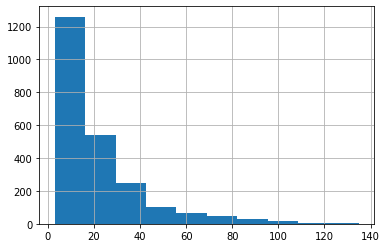

In [73]:
excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR"]).number_of_visits.hist()

### Time range

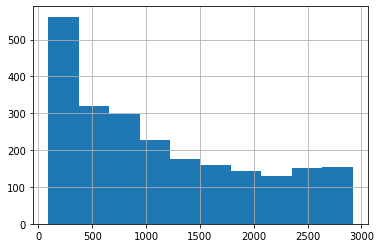

In [74]:
excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR"]).time_range.hist()

## Get only eyes which are naive to the eye clinic itself

In [75]:
inj_date = pd.DataFrame(date_min_max["study_date_dt"]["amin"])

inj_date = inj_date.rename(columns={"amin": "first_oct_date"})
inj_date["PATNR"] = date_min_max[["PATNR"]]
inj_date["laterality"] = date_min_max[["laterality"]]

treatment_naive = pd.merge(excluded_longitudinal_amd_inj[["PATNR", "laterality", "INJECTION_first_date"]], 
         inj_date[["PATNR", "laterality", "first_oct_date"]], 
         left_on=["PATNR", "laterality"], 
         right_on=["PATNR", "laterality"], 
         how="left")

treatment_naive_seq = treatment_naive.drop_duplicates(subset=["PATNR", "laterality"])

In [ ]:
eye_clinic_treatment_naive = pd.to_datetime(treatment_naive_seq["INJECTION_first_date"]) < \
pd.to_datetime(treatment_naive_seq["first_oct_date"])

treatment_naive_seq["oct_after_injections"] = eye_clinic_treatment_naive

### Join with meta table

## Merge Treatment naive patients logging

In [ ]:
excluded_longitudinal_amd_inj = pd.merge(excluded_longitudinal_amd_inj, 
         treatment_naive_seq[["PATNR", "laterality", "oct_after_injections"]], 
         left_on = ["PATNR", "laterality"], 
         right_on=["PATNR", "laterality"], how="left")

### Filter for treatment naive patients

In [ ]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj[excluded_longitudinal_amd_inj.oct_after_injections == False]

In [ ]:
print("Number of patients treatment naive at Eye clinic", 
      excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR"]).shape[0])

#### Drop any duplicate records

In [ ]:
excluded_longitudinal_amd_inj = excluded_longitudinal_amd_inj.drop_duplicates(subset=["PATNR", "laterality", "study_date"])

In [ ]:
excluded_longitudinal_amd_inj

## Check export overlap

In [ ]:
np.unique(excluded_longitudinal_amd_inj.export, return_counts=True)

In [ ]:
patient_bool = excluded_longitudinal_amd_inj.PATNR == 367711
laterality_bool = excluded_longitudinal_amd_inj.laterality == "R"

excluded_longitudinal_amd_inj[patient_bool & laterality_bool][["PATNR", 
                                                               "laterality", 
                                                               "study_date", 
                                                               "export",
                                                               "INJECTION_first_date", 
                                                               "DKEY_first_date"]]

In [ ]:
longitudinal_export_1_pd[longitudinal_export_1_pd.PATNR == 265145]

In [ ]:
longitudinal_export_2_pd[longitudinal_export_2_pd.PATNR == 265145]

In [ ]:
joint_prozeduren_pd[joint_prozeduren_pd.PATNR == 265145]

## Save potential additional time series data

In [ ]:
EXT = "joint_export/longitudinal_tables"
excluded_longitudinal_amd_inj.to_csv(os.path.join(PROJ_DIR, EXT, "oct_meta_longitudinal_naive_information.csv"), 
                                     index=False)

In [ ]:
column_oi = ["PATNR", "birthdate", "DKEY_first_date", "INJECTION_first_date", "time_range", "number_of_visits"]
patient_unique_longitudinal_amd_inj = excluded_longitudinal_amd_inj[column_oi].drop_duplicates(subset=["PATNR"])

patient_unique_longitudinal_amd_inj.to_csv(os.path.join(PROJ_DIR, 
                                                        EXT, 
                                                        "oct_meta_patient_uniquelongitudinal_naive.csv"), 
                                     index=False)